In [0]:
import numpy as np
import pandas as pd
from scipy import stats
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin
from scipy import stats
from sklearn import metrics
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path =  "/content/drive/My Drive/bond_trading/"

data = pd.read_excel(path + '1W - Dataset.xlsx')
data.head()

Date         CO1  ...  Current Rate  5YearWeekly
0  2019-11-22 00:00:00  11409.5661  ...          9.45        10.00
1  2019-11-15 00:00:00  11406.6600  ...         10.10         9.45
2  2019-11-08 00:00:00  11297.4323  ...         10.05        10.10
3  2019-11-01 00:00:00  11169.5914  ...         10.10        10.05
4  2019-10-25 00:00:00  11239.8846  ...          9.98        10.10

[5 rows x 24 columns]

In [0]:
def date_parser(data):
  """
  to parse the date columns and split in to year, month, day, hour and minute
  args :
    data : dataframe
  return :
    df : dataframe with date columns splited into month, year, day, hour and minute
  """
  df = data.copy()
  for col in df.columns:
    if df[col].dtype == 'object':
        try:
          df[col] = pd.to_datetime(df[col])
        except ValueError:
          pass
  for col in df.columns:
    if df[col].dtype == 'datetime64[ns]':
      df[col] = df[col].apply(lambda x : parse(str(x)))
      df[f'year_{col}'] = df[col].apply(lambda x : x.year)
      df[f'month_{col}'] = df[col].apply(lambda x : x.month)
      df[f'day_{col}'] = df[col].apply(lambda x : x.day)
      df.drop(col, axis = 1, inplace = True)
  return df


date_df = date_parser(data)
date_df.head()

CO1  USGG5YRIndex  USGG10YRIndex  ...  year_Date  month_Date  day_Date
0  11409.5661          1.62           1.77  ...       2019          11        22
1  11406.6600          1.65           1.83  ...       2019          11        15
2  11297.4323          1.75           1.94  ...       2019          11         8
3  11169.5914          1.54           1.71  ...       2019          11         1
4  11239.8846          1.62           1.79  ...       2019          10        25

[5 rows x 26 columns]

In [0]:
df_drop = date_df.dropna()
df_drop.head()

CO1  USGG5YRIndex  USGG10YRIndex  ...  year_Date  month_Date  day_Date
0  11409.5661          1.62           1.77  ...       2019          11        22
1  11406.6600          1.65           1.83  ...       2019          11        15
2  11297.4323          1.75           1.94  ...       2019          11         8
3  11169.5914          1.54           1.71  ...       2019          11         1
4  11239.8846          1.62           1.79  ...       2019          10        25

[5 rows x 26 columns]

In [0]:
print(date_df.shape)
print(df_drop.shape)

(350, 26)
(349, 26)


In [0]:
def get_feature_cols(df, label):
  feature_cols = df.columns.drop(label)
  return feature_cols


def get_X_y(df, label):
  feature_cols = get_feature_cols(df, label)
  return df[feature_cols], df[label]

X, y = get_X_y(df_drop, '5YearWeekly')

X.head()

CO1  USGG5YRIndex  USGG10YRIndex  ...  year_Date  month_Date  day_Date
0  11409.5661          1.62           1.77  ...       2019          11        22
1  11406.6600          1.65           1.83  ...       2019          11        15
2  11297.4323          1.75           1.94  ...       2019          11         8
3  11169.5914          1.54           1.71  ...       2019          11         1
4  11239.8846          1.62           1.79  ...       2019          10        25

[5 rows x 25 columns]

In [0]:
def data_split(X, y):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
  return X_train, X_test, y_train, y_test 


X_train, X_test, y_train, y_test = data_split(X, y)

In [0]:
def base_model(X_train, X_test, y_train, y_test):
  """
  base model for evaluating the dataframe
  """
  dtrain = lgb.Dataset(X_train, label=y_train)
  dvalid = lgb.Dataset(X_test, label=y_test)

  params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 64,
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
  }

  print('Starting training...')
  # train
  gbm = lgb.train(params,
                  dtrain,
                  num_boost_round=12000,
                  valid_sets=dvalid,
                  early_stopping_rounds=2500)
  valid_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
  # eval
  valid_score = metrics.mean_squared_error(y_test, valid_pred) ** 0.5


  print(f"Validation rmse error: {valid_score:.4f}")
  return valid_score, gbm , valid_pred

In [0]:
valid_score, gbm , valid_pred = base_model(X_train, X_test, y_train, y_test)

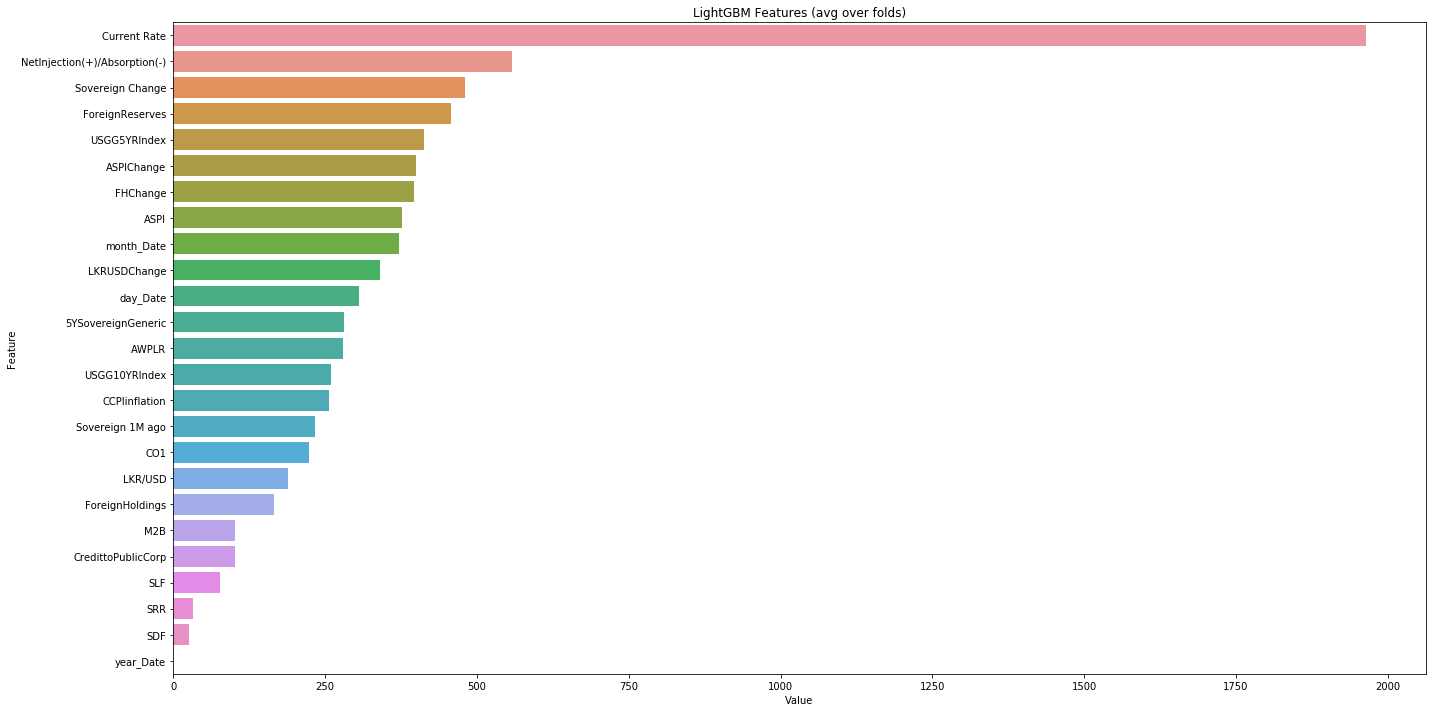

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [0]:
X_test.columns

Index(['CO1', 'USGG5YRIndex', 'USGG10YRIndex', '5YSovereignGeneric',
       'Sovereign Change', 'Sovereign 1M ago', 'SDF', 'SLF', 'SRR', 'M2B',
       'CredittoPublicCorp', 'ForeignHoldings', 'FHChange', 'LKR/USD',
       'LKRUSDChange', 'AWPLR', 'NetInjection(+)/Absorption(-)',
       'ForeignReserves', 'ASPI', 'ASPIChange', 'CCPIinflation',
       'Current Rate', 'year_Date', 'month_Date', 'day_Date'],
      dtype='object')

In [0]:
!pip install pdpbox

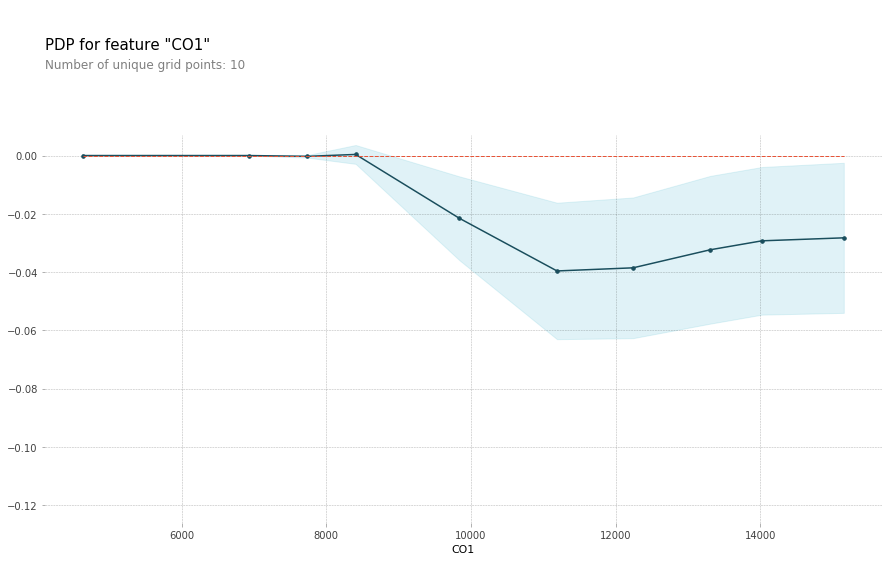

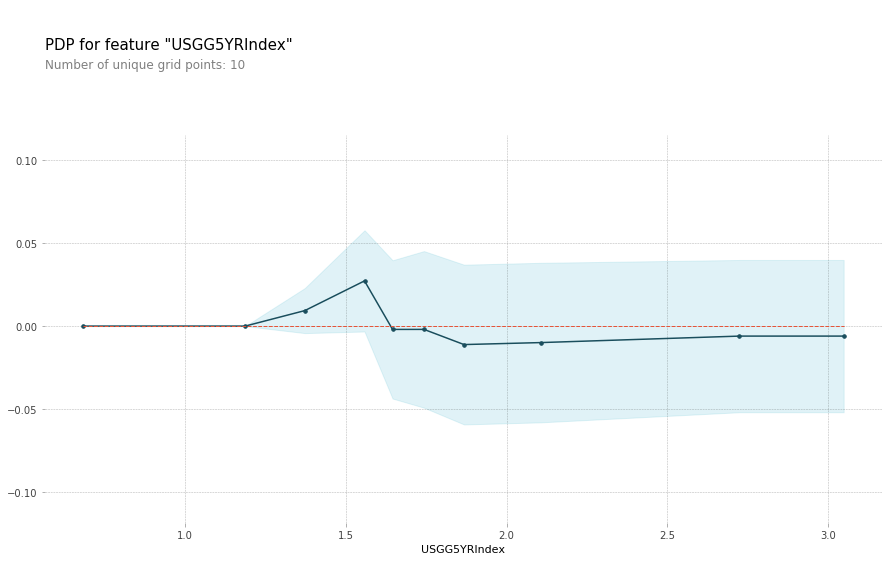

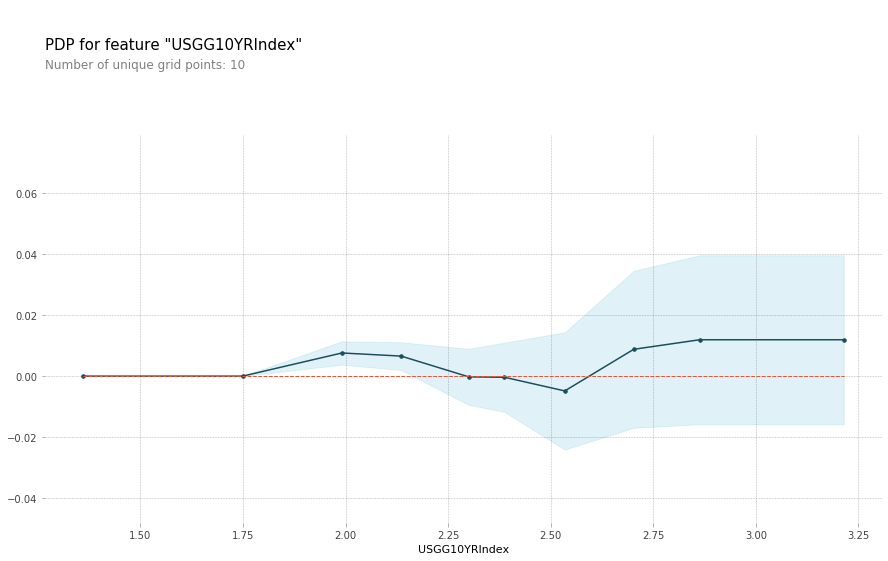

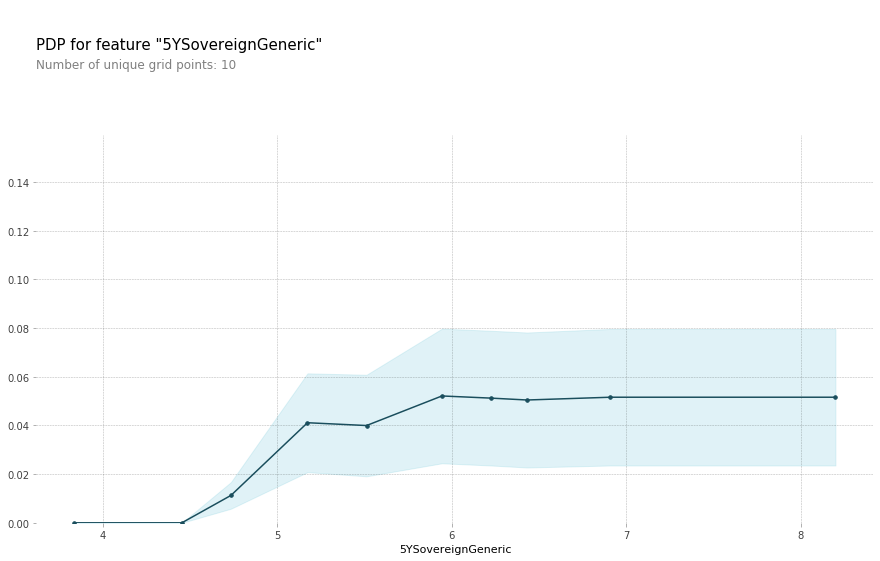

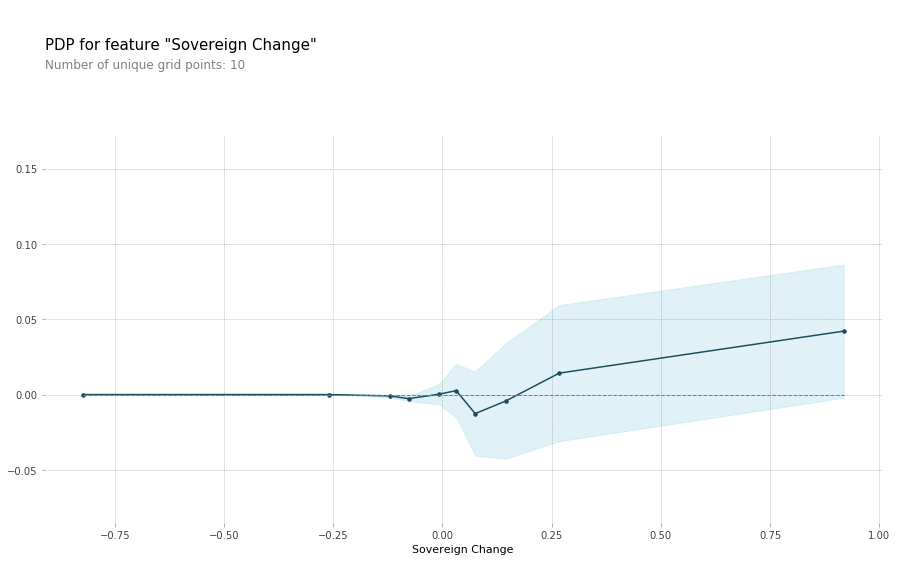

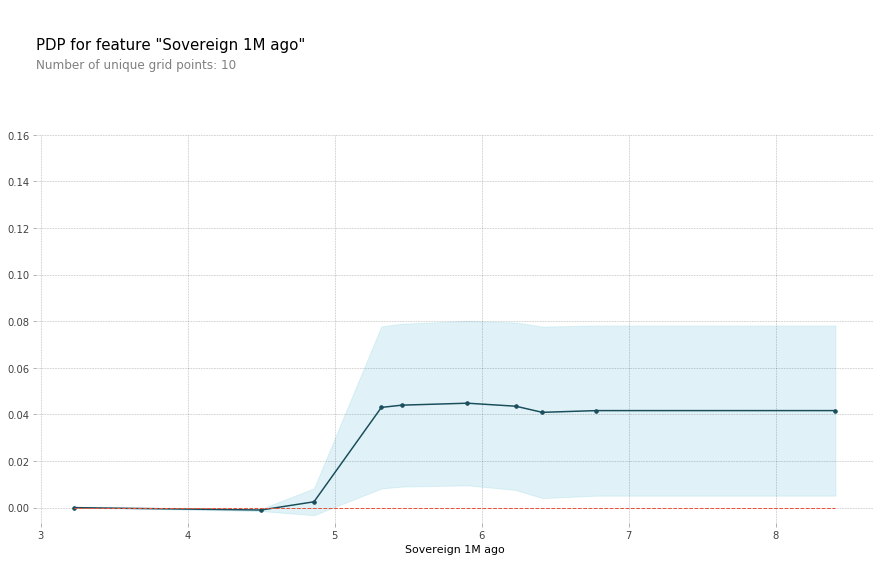

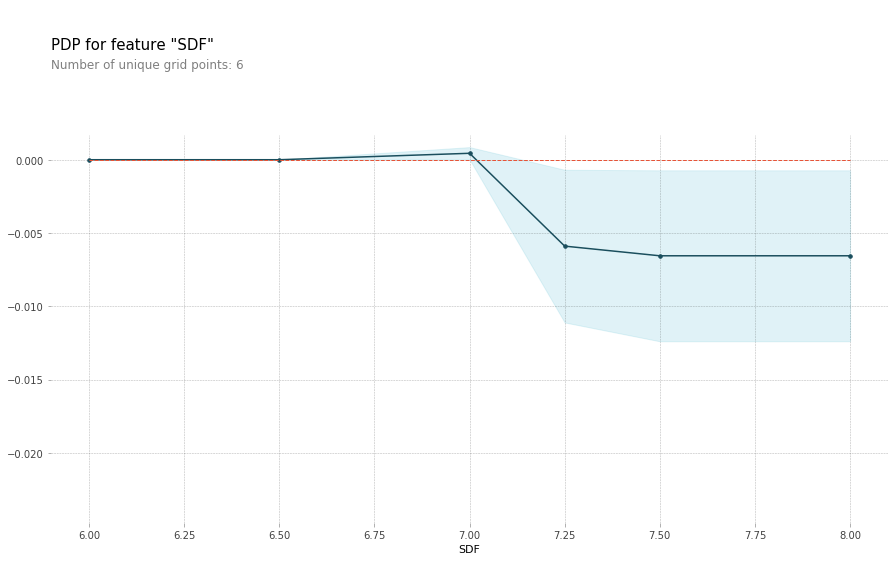

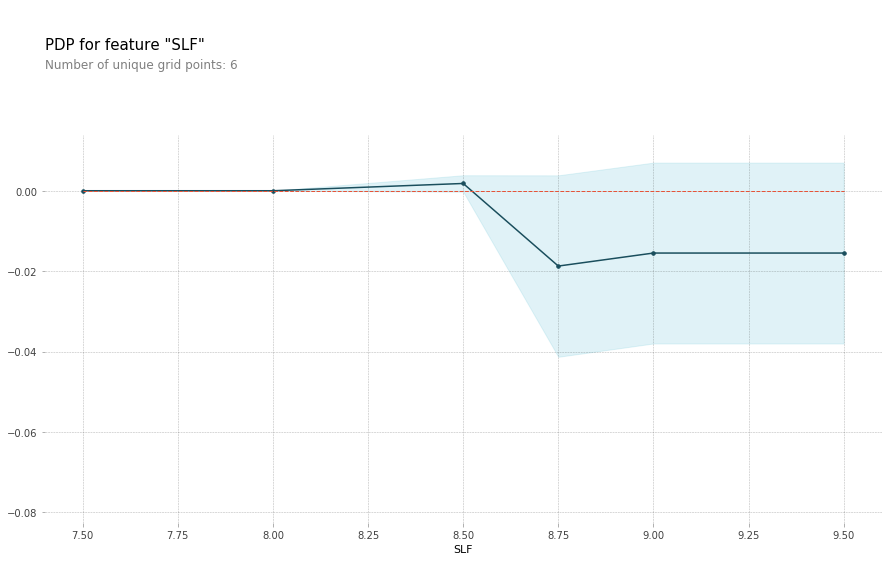

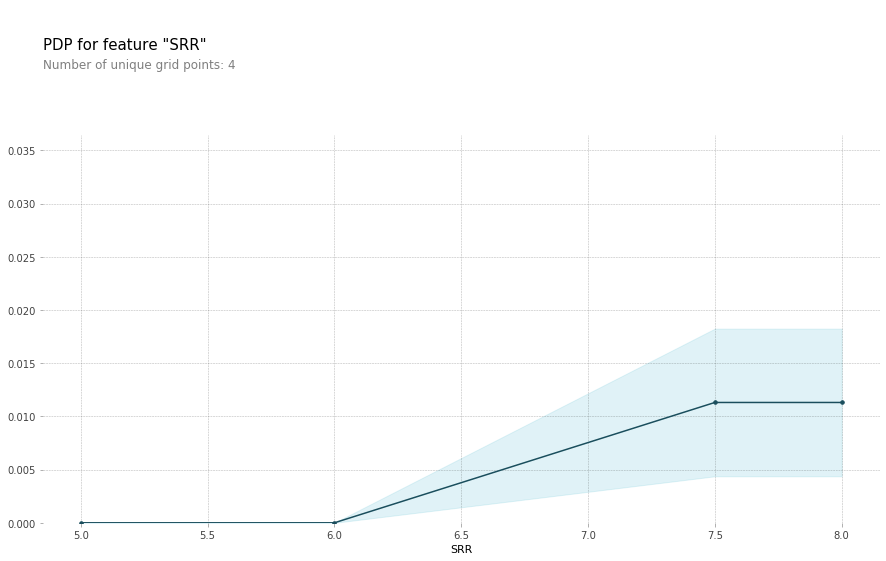

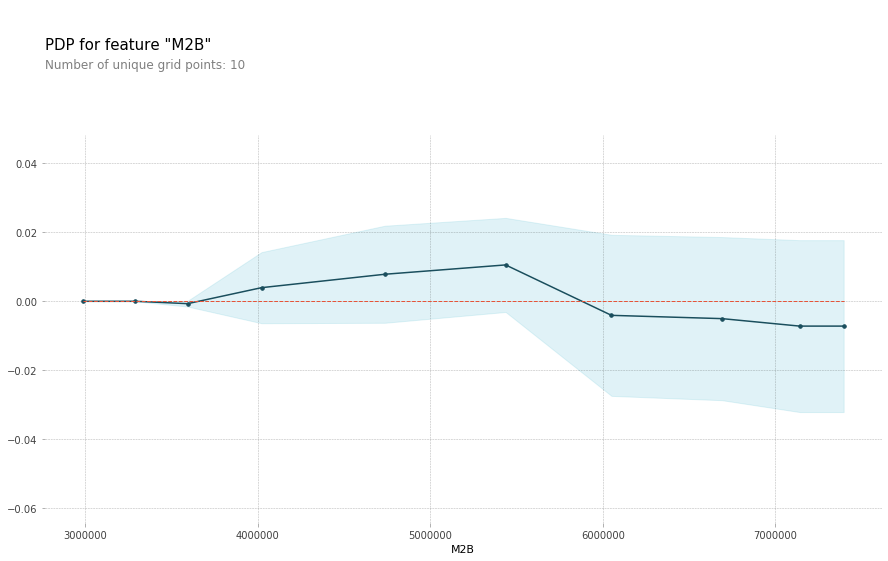

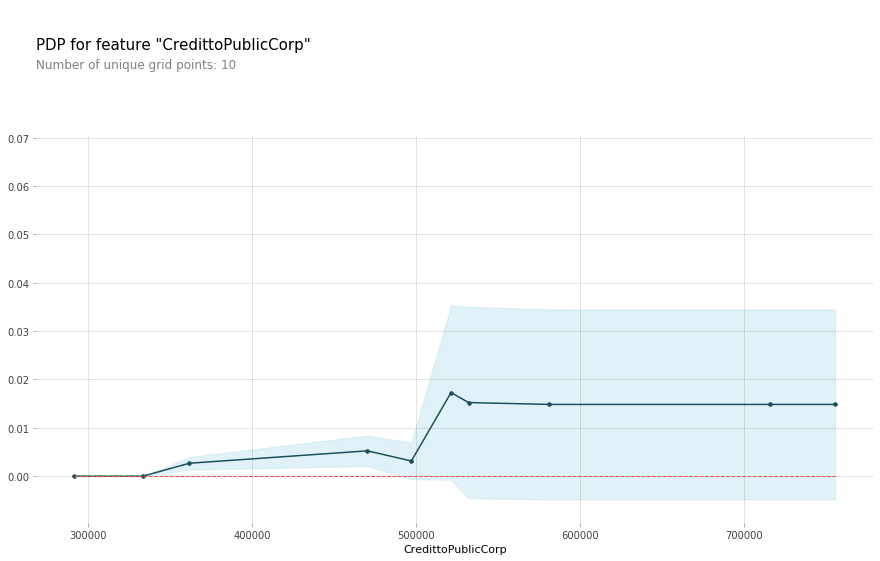

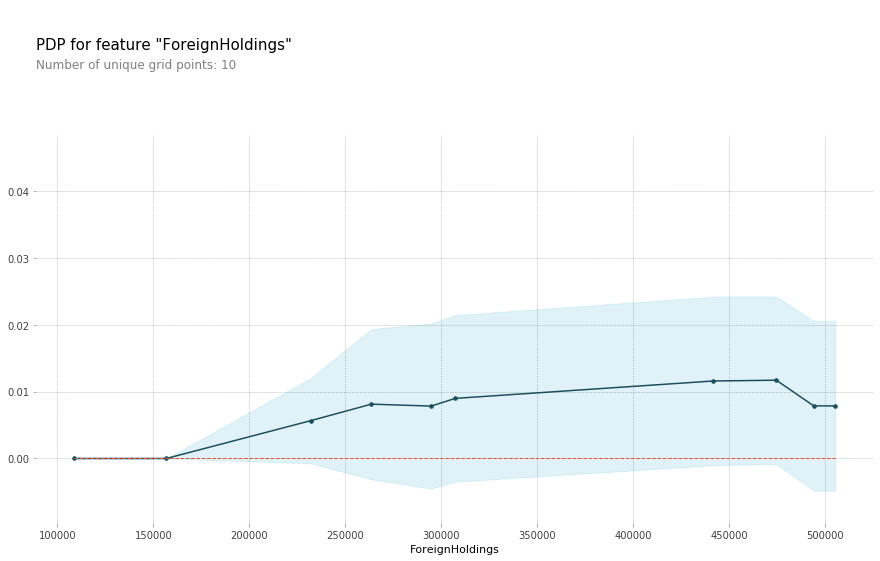

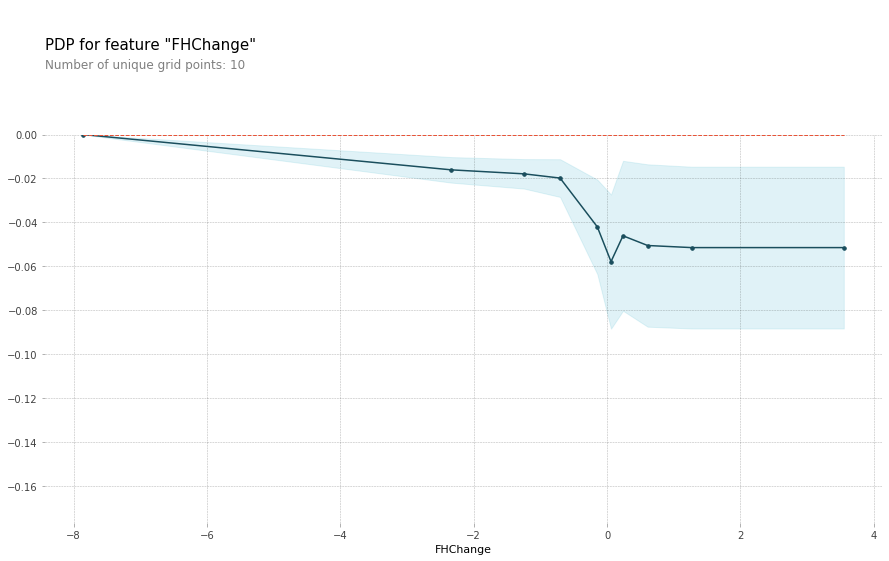

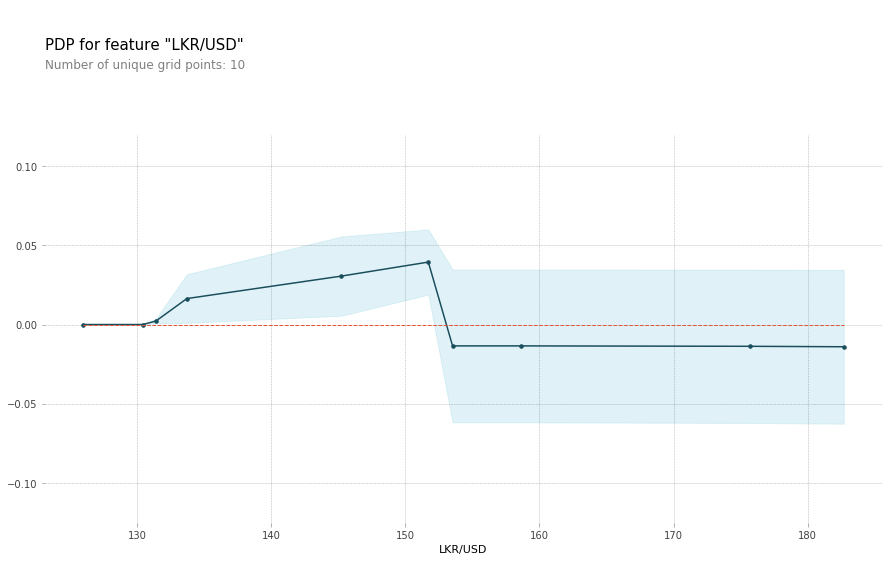

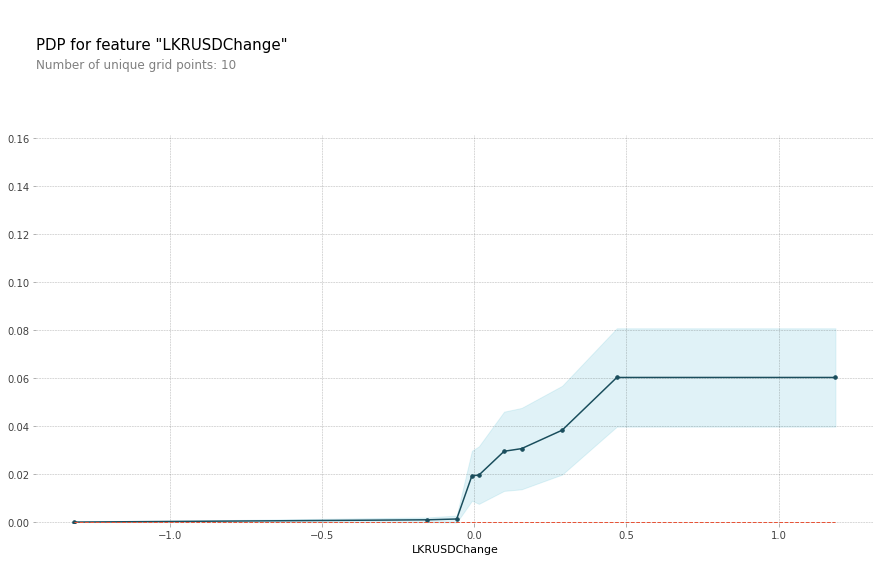

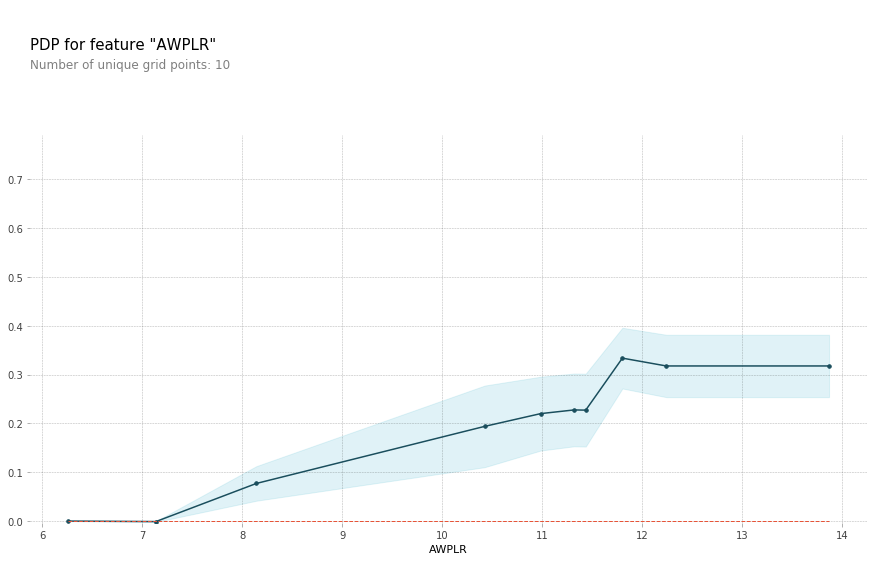

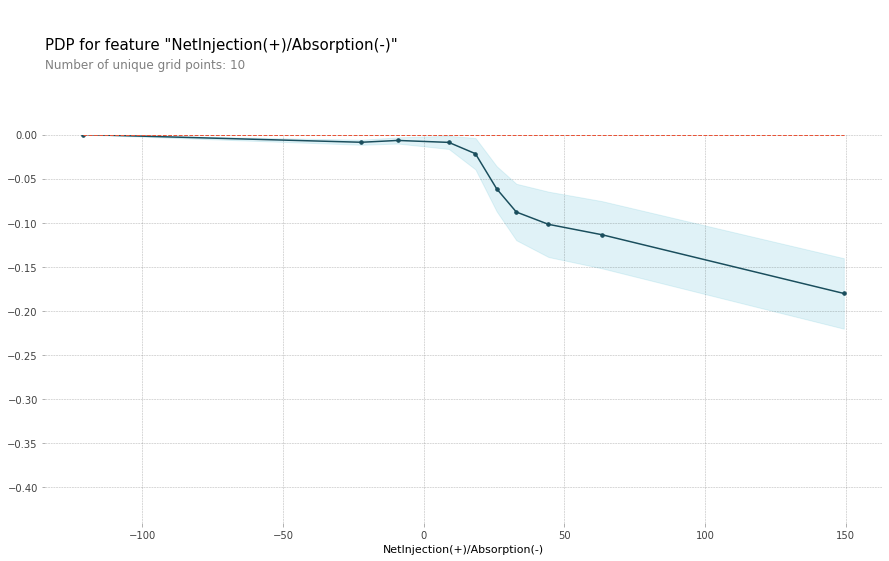

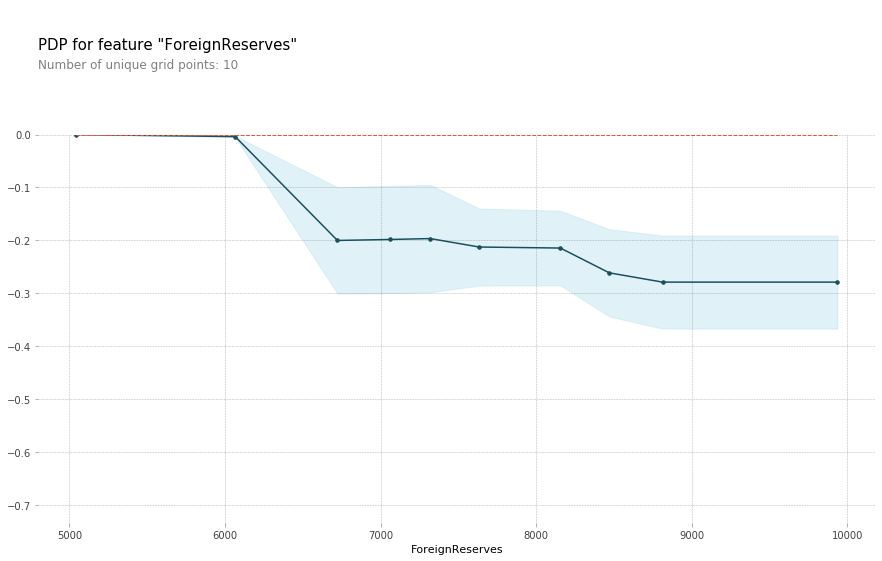

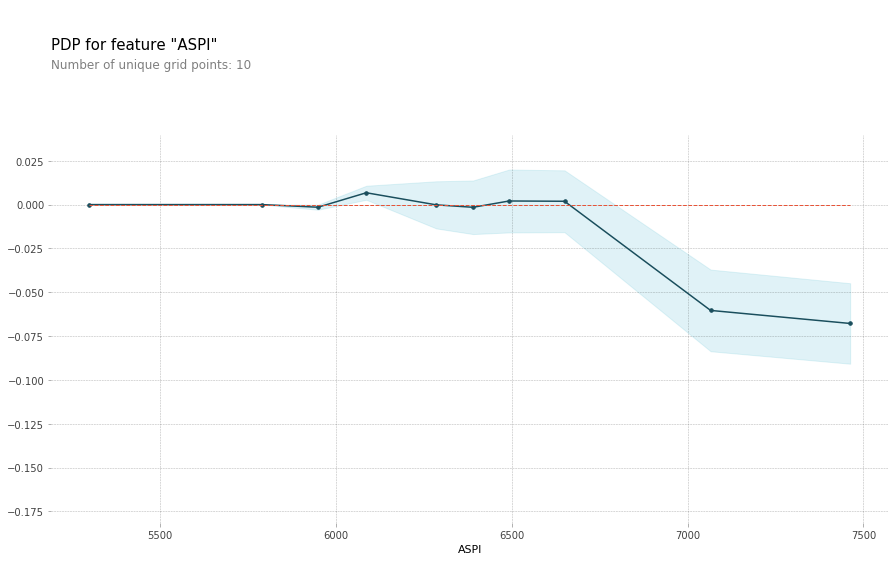

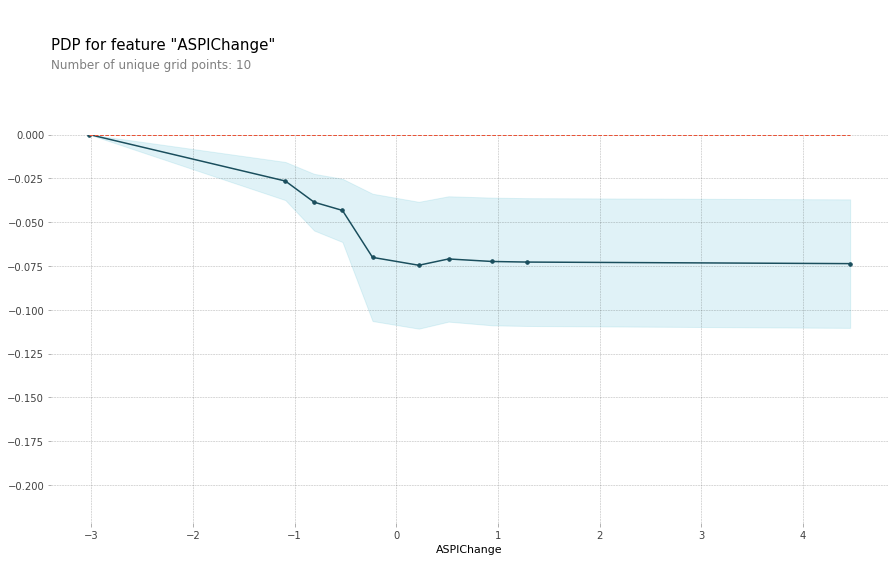

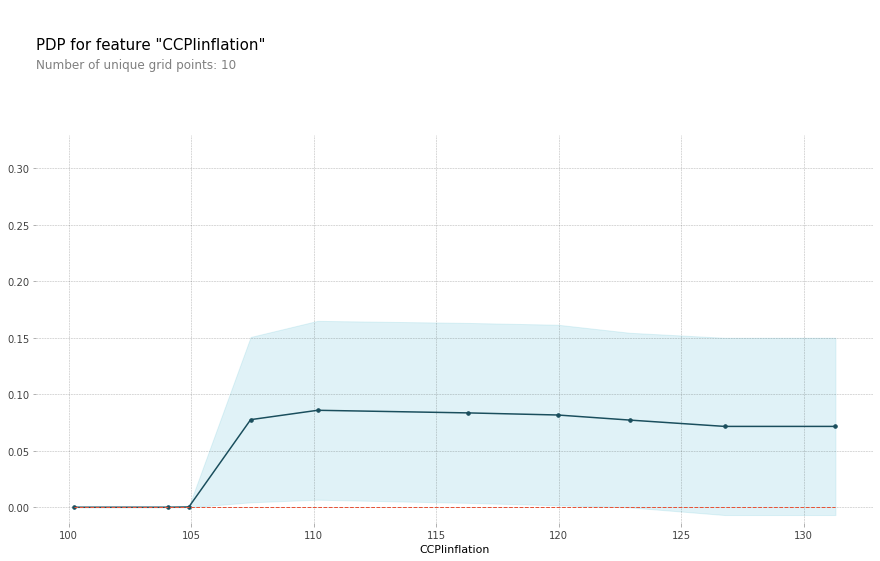

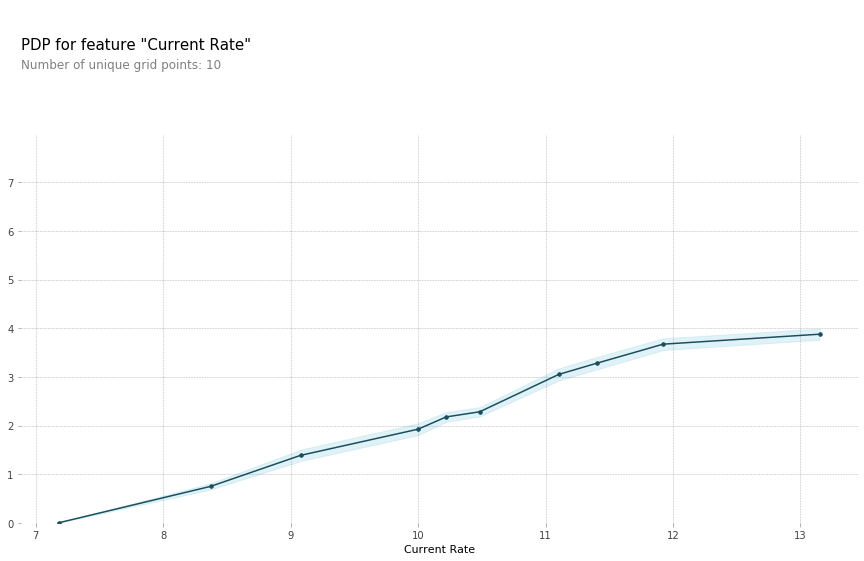

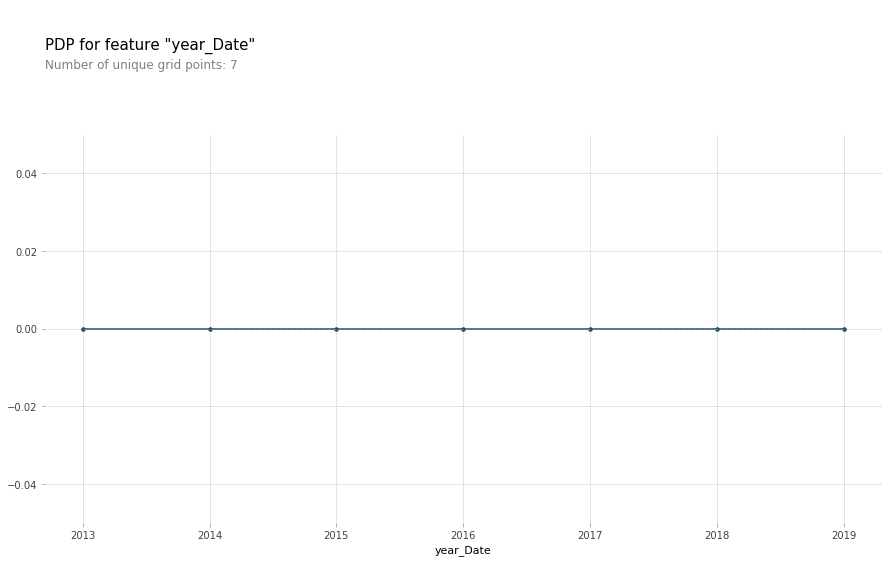

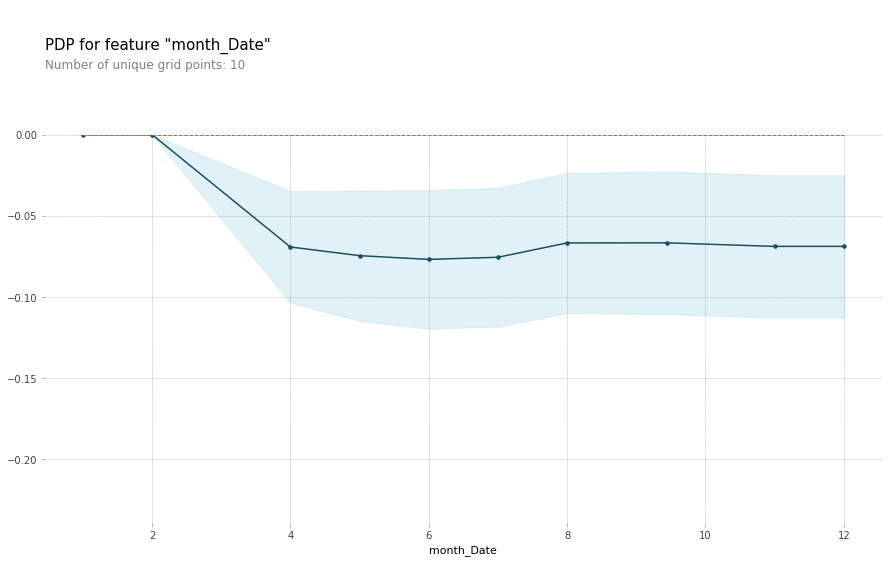

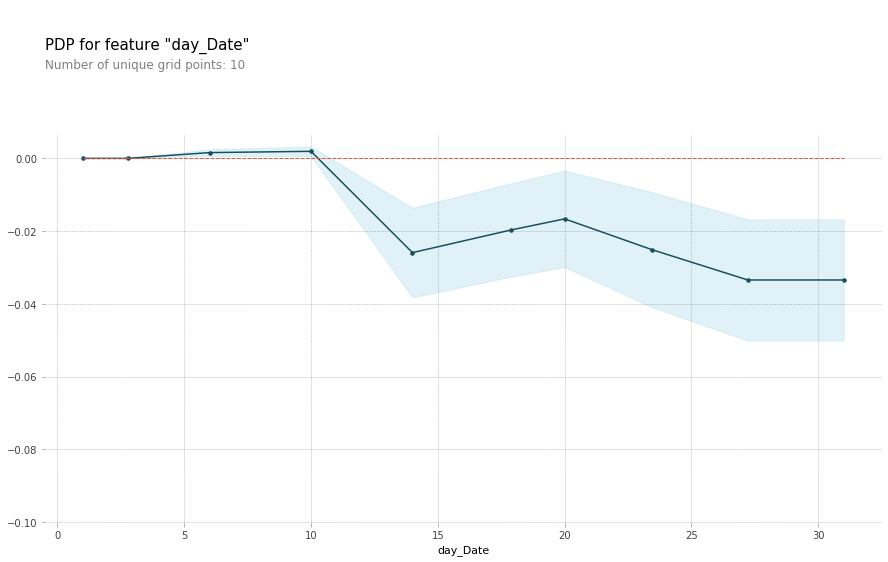

In [0]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

for j in X_test.columns :
  feature_names = [i for i in X_test.columns]

  feature = j
  # Create the data that we will plot
  pdp_isolate = pdp.pdp_isolate(model=gbm, dataset=X_test, model_features=feature_names, feature=feature)

  # plot it
  pdp.pdp_plot(pdp_isolate, feature)
  plt.show()

In [0]:
data = pd.read_excel(path + '8W - Data set.xlsx')
data.head()

Date         CO1  ...  Current Rate  5Year8Weeks
0  2019-10-04 00:00:00  10585.9832  ...         10.27        10.00
1  2019-09-27 00:00:00  11257.0953  ...         10.30         9.45
2  2019-09-20 00:00:00  11646.2504  ...         10.30        10.10
3  2019-09-12 00:00:00  10889.5330  ...         10.35        10.05
4  2019-09-06 00:00:00  11132.5860  ...         10.04        10.10

[5 rows x 24 columns]

In [0]:
date_df = date_parser(data)

df_drop = date_df.dropna()

print(date_df.shape)
print(df_drop.shape)

(343, 26)
(342, 26)


In [0]:
X, y = get_X_y(df_drop, '5Year8Weeks')


X_train, X_test, y_train, y_test = data_split(X, y)

In [0]:
def base_model(X_train, X_test, y_train, y_test):
  """
  base model for evaluating the dataframe
  """
  dtrain = lgb.Dataset(X_train, label=y_train)
  dvalid = lgb.Dataset(X_test, label=y_test)

  params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 64,
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
  }

  print('Starting training...')
  # train
  gbm = lgb.train(params,
                  dtrain,
                  num_boost_round=50000,
                  valid_sets=dvalid,
                  early_stopping_rounds=2500)
  valid_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
  # eval
  valid_score = metrics.mean_squared_error(y_test, valid_pred) ** 0.5


  print(f"Validation rmse error: {valid_score:.4f}")
  return valid_score, gbm , valid_pred

In [0]:
valid_score, gbm , valid_pred = base_model(X_train, X_test, y_train, y_test)

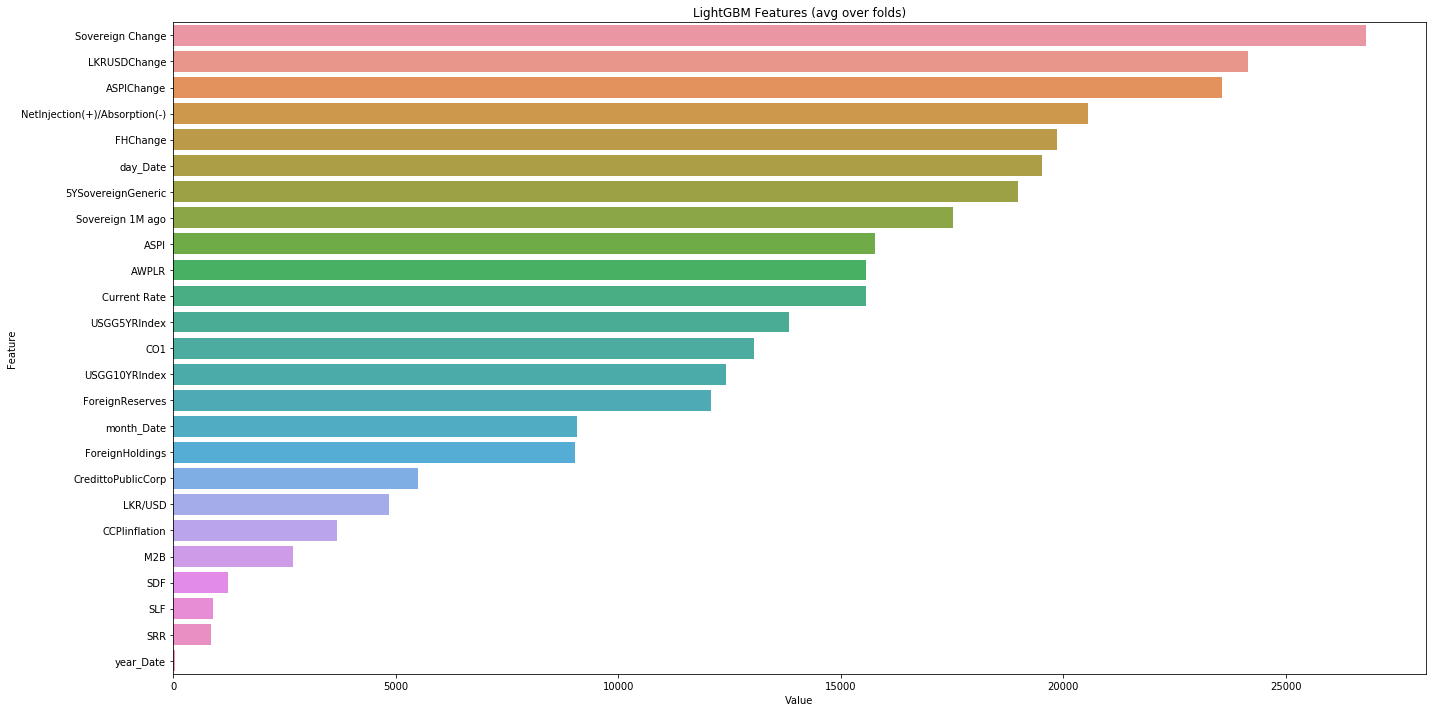

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

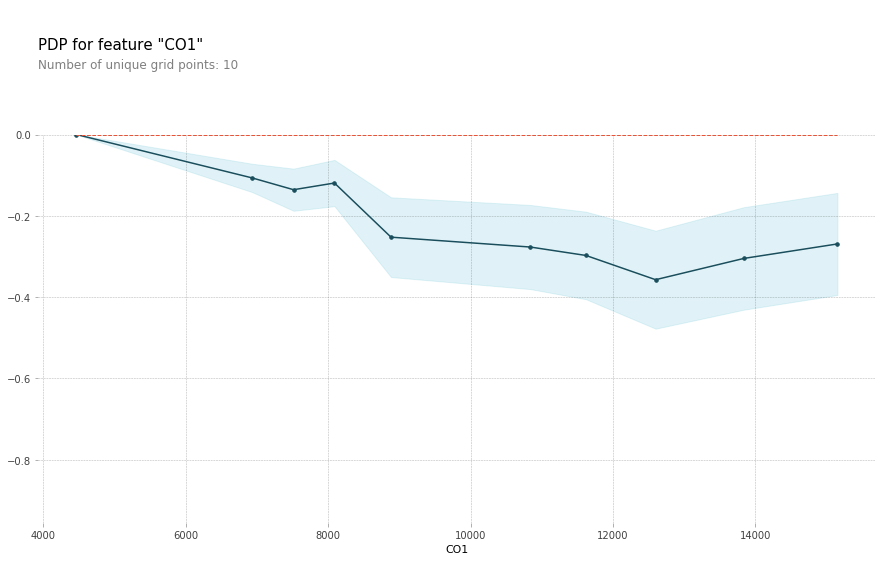

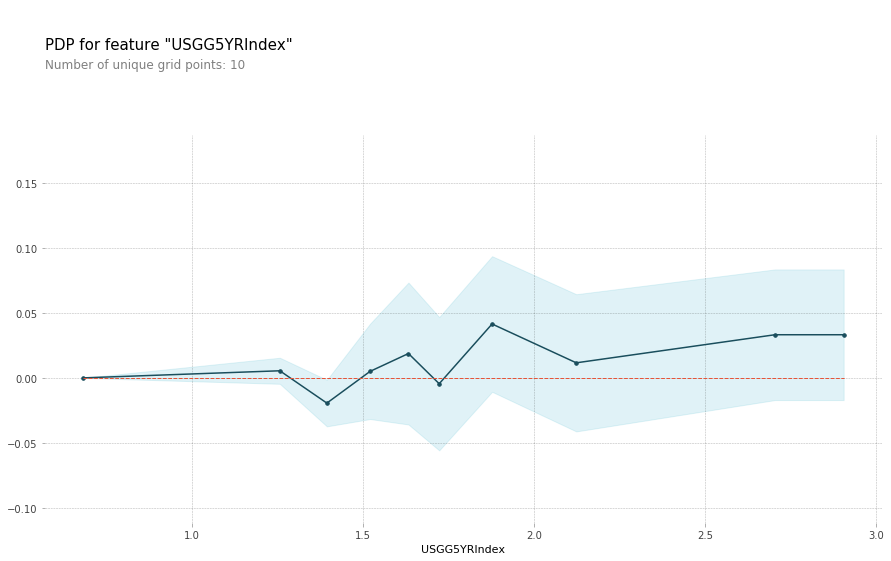

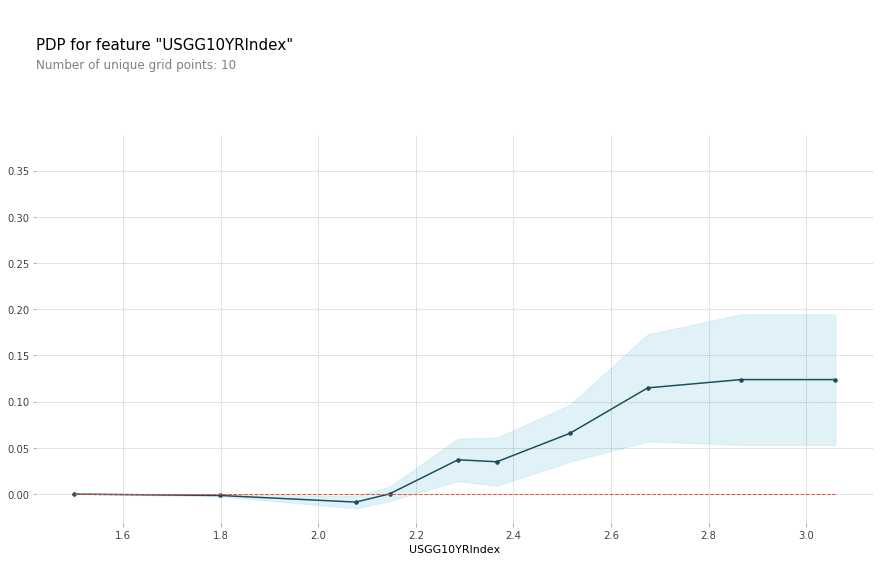

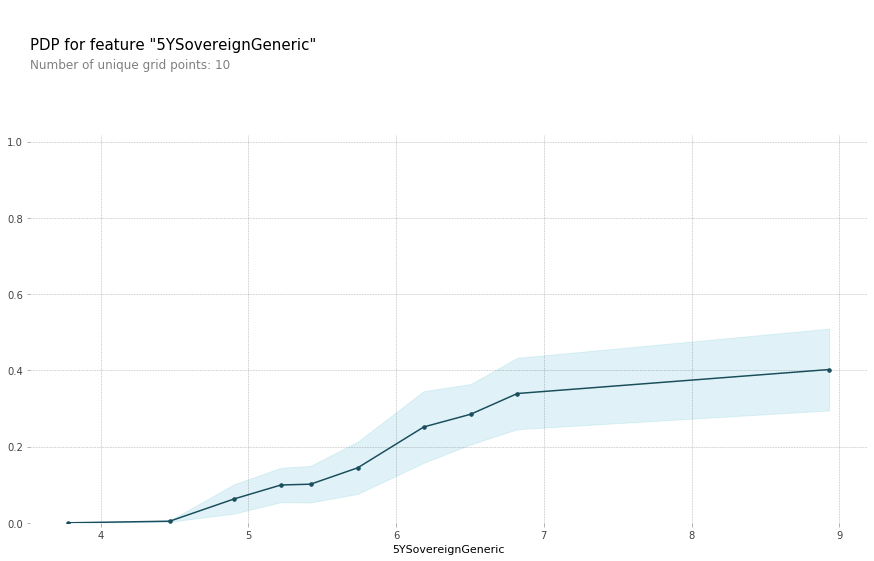

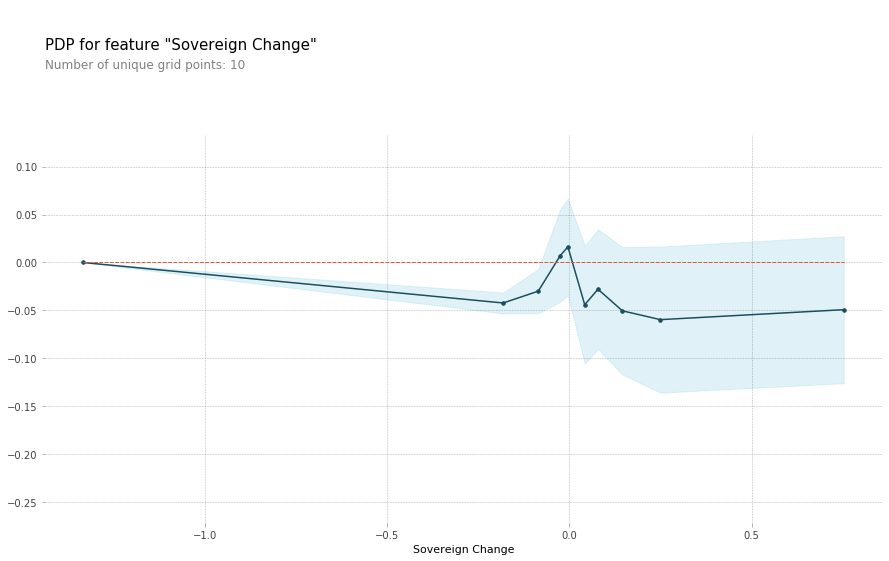

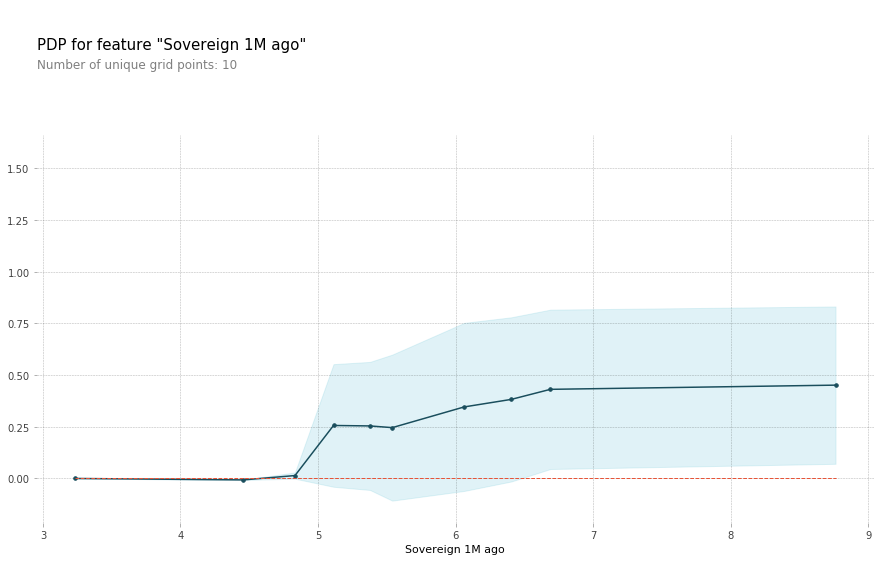

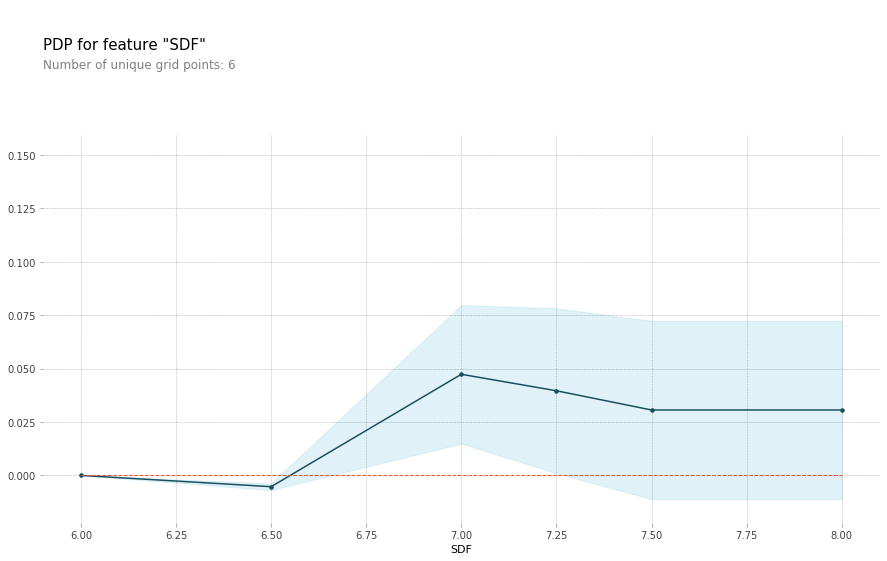

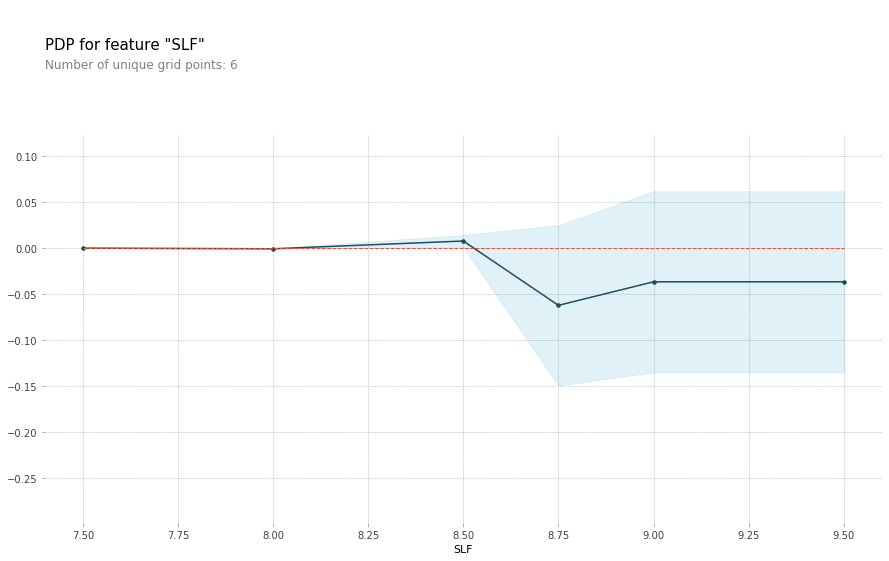

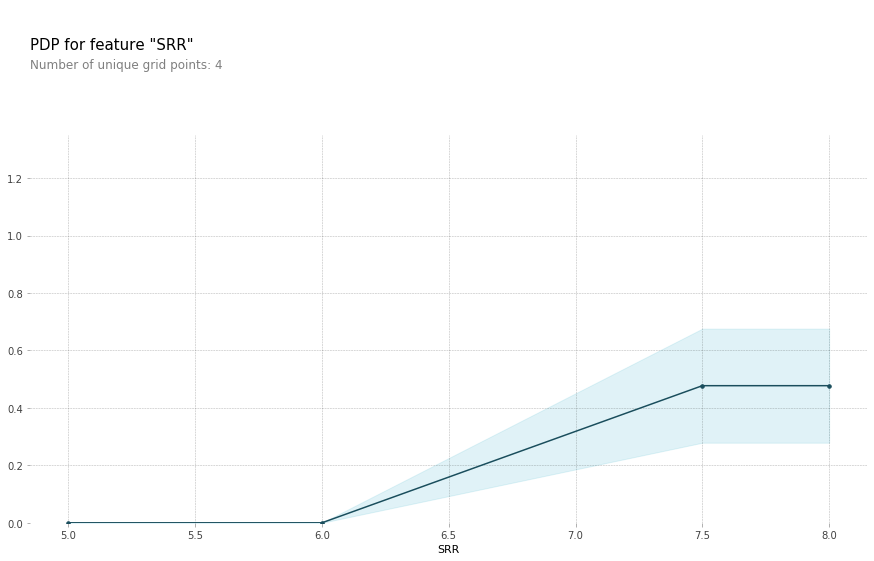

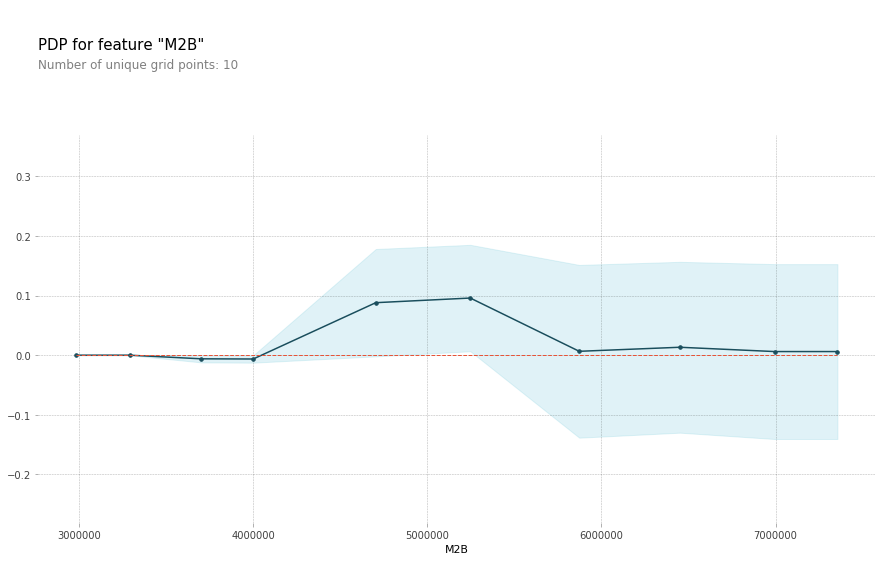

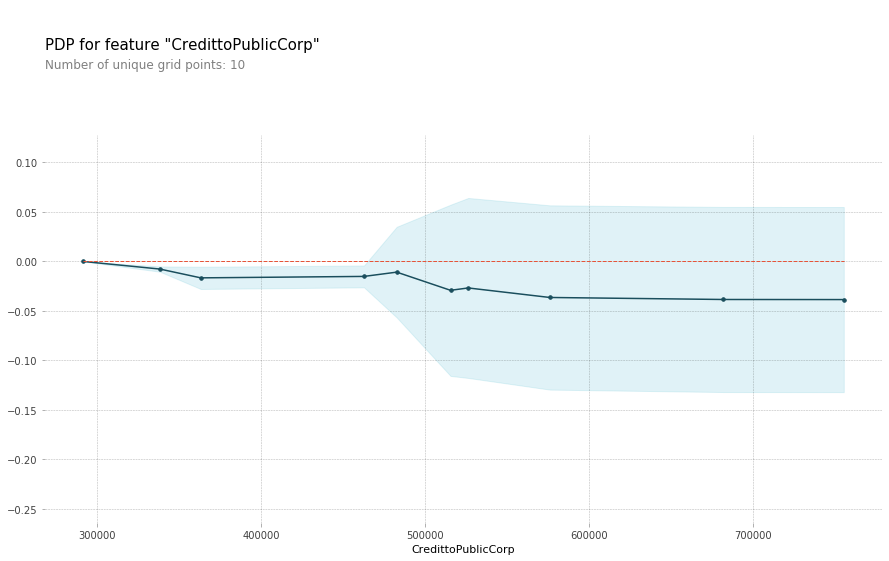

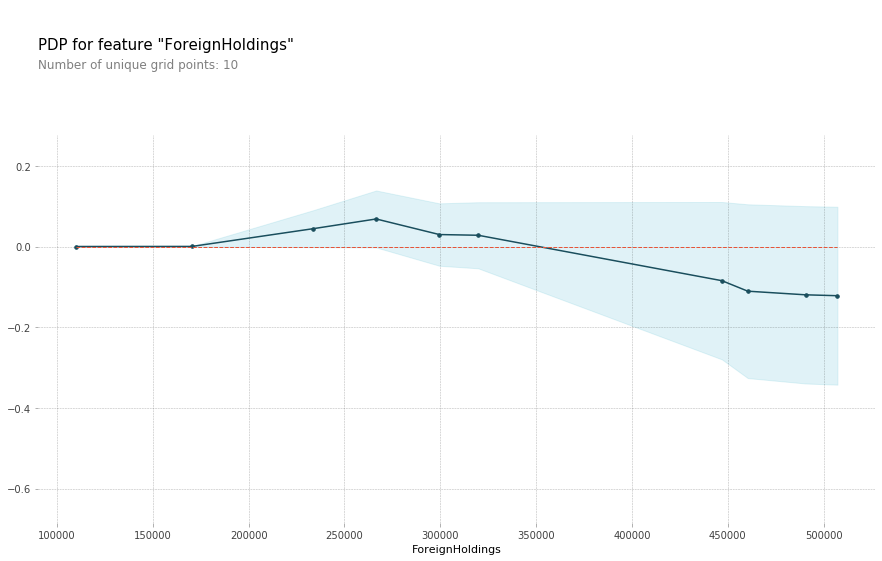

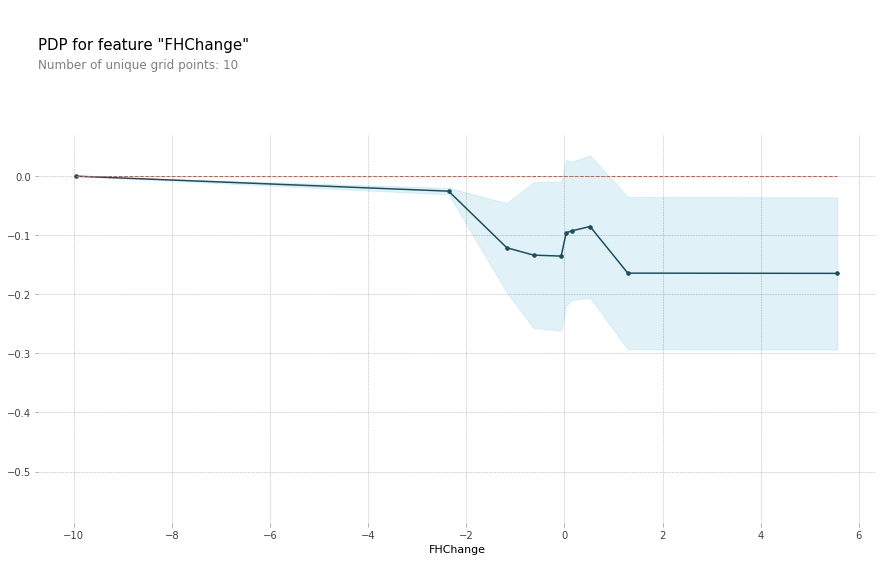

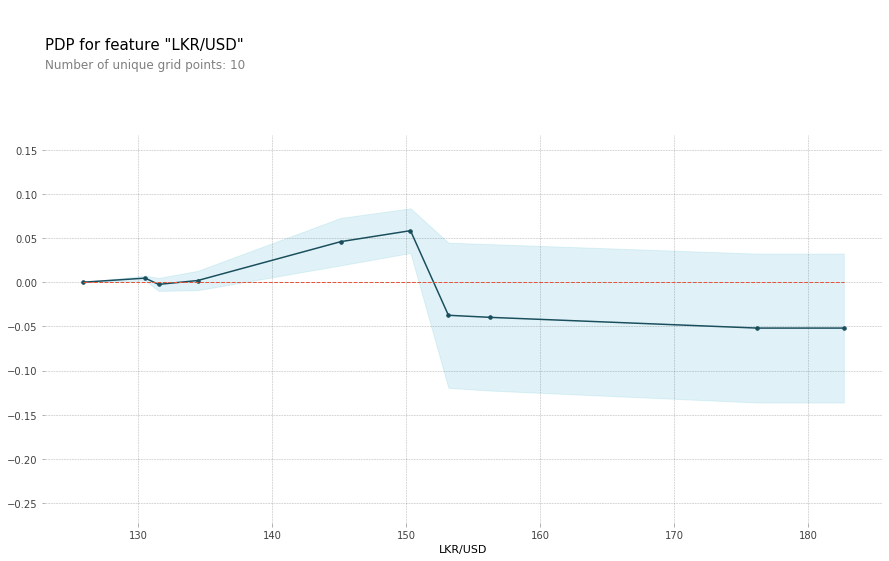

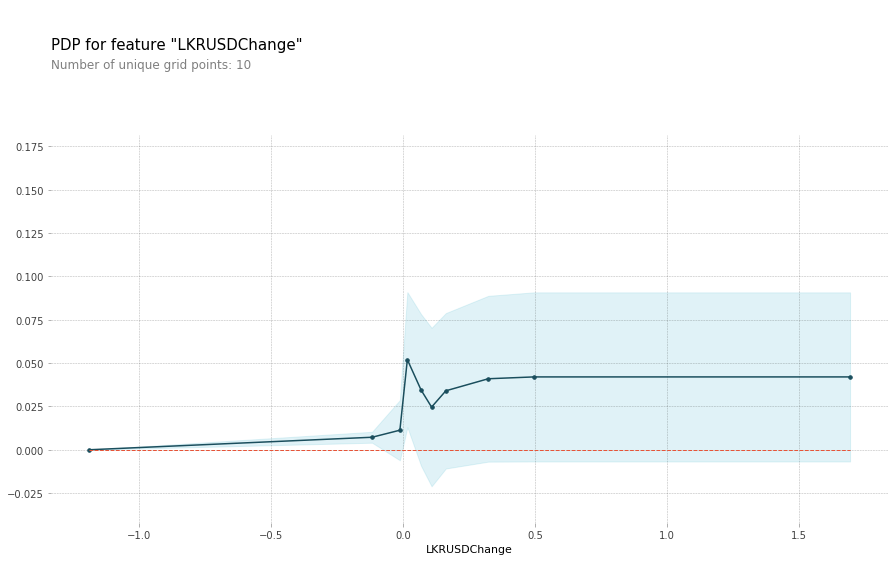

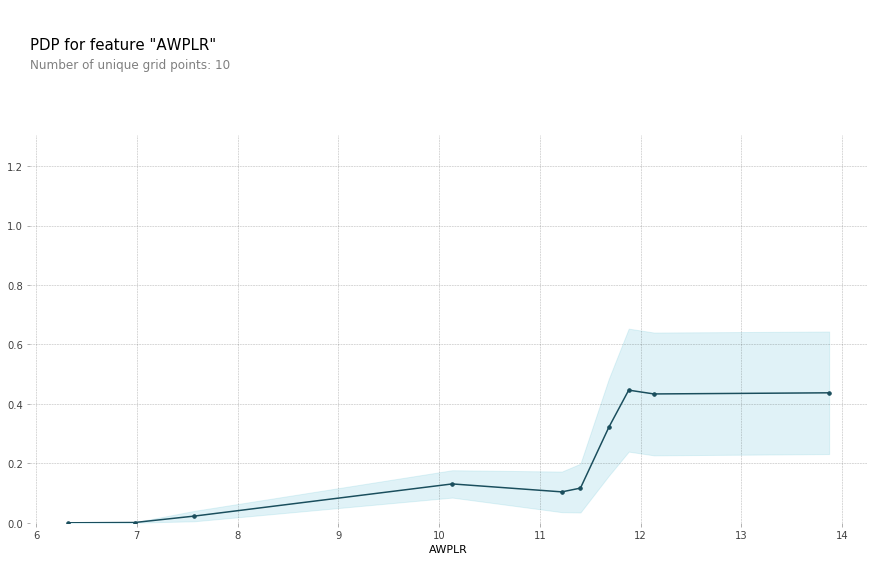

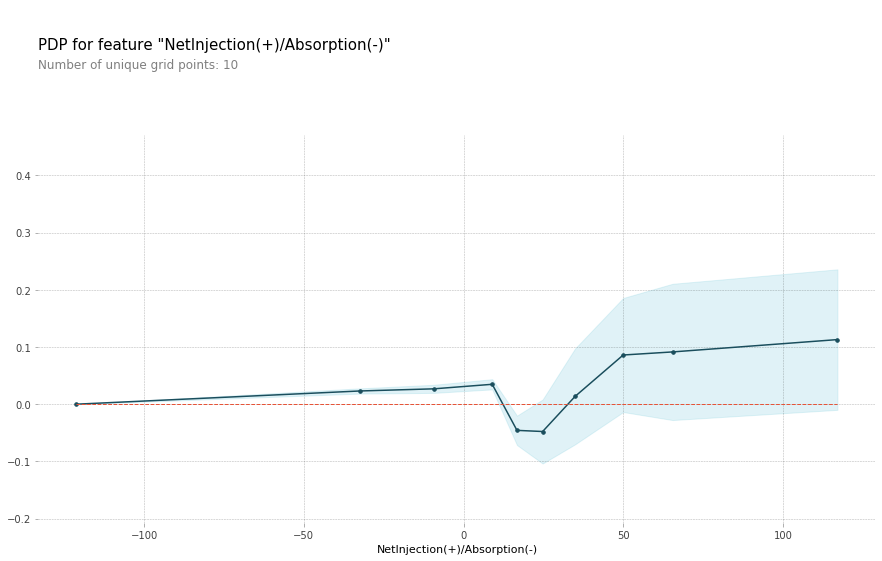

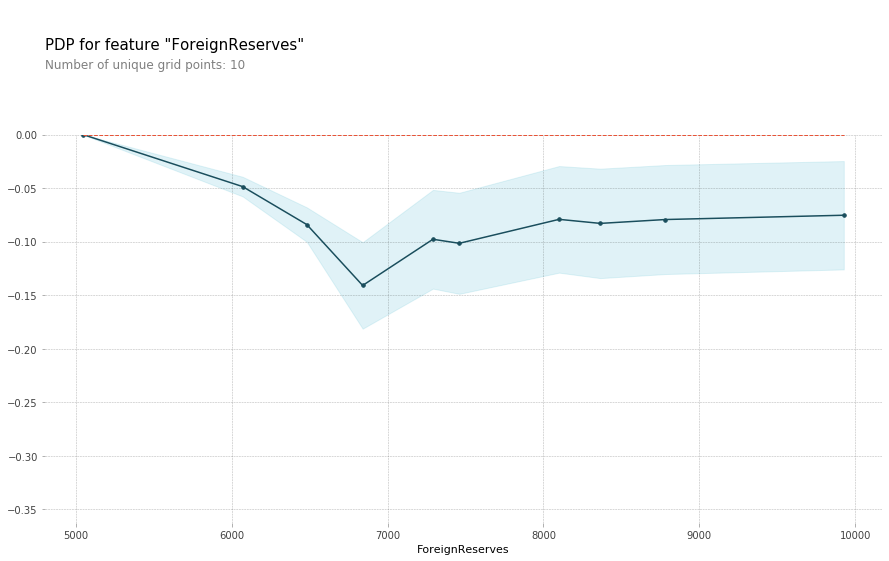

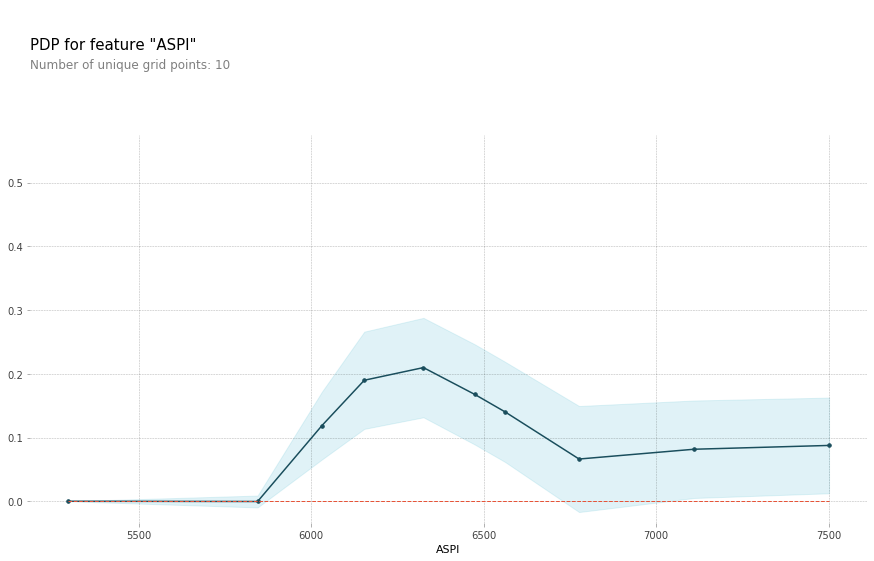

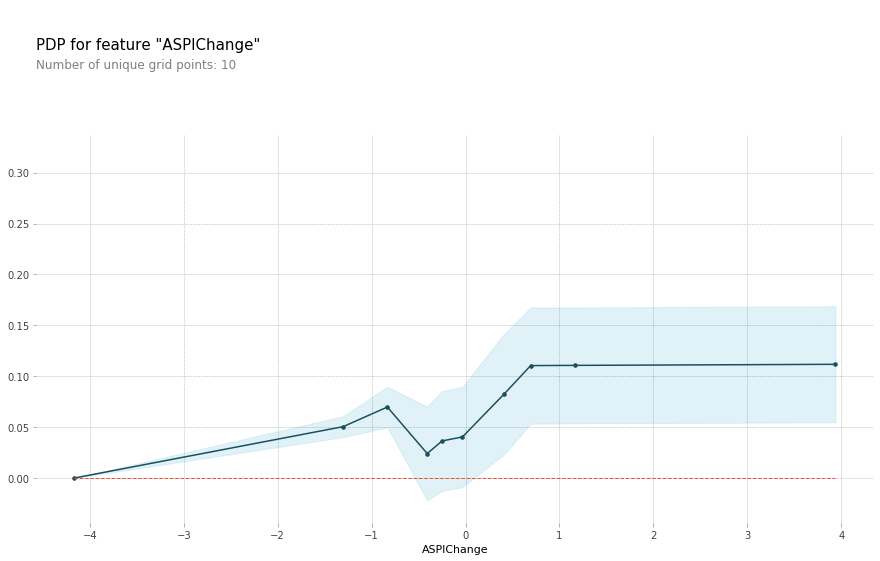

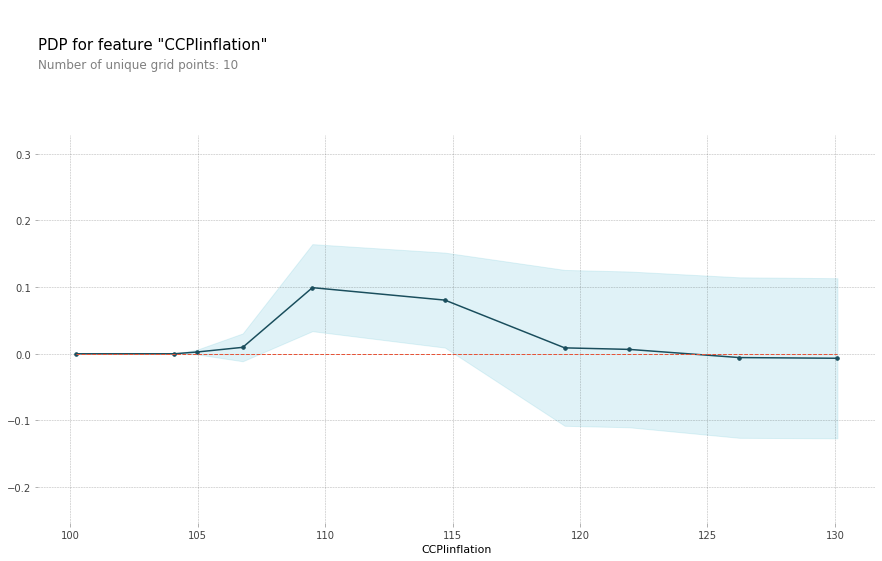

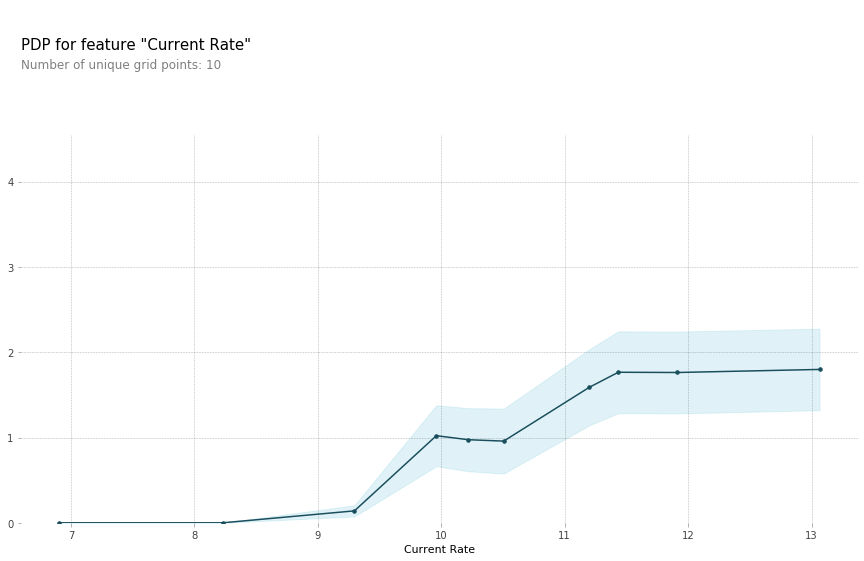

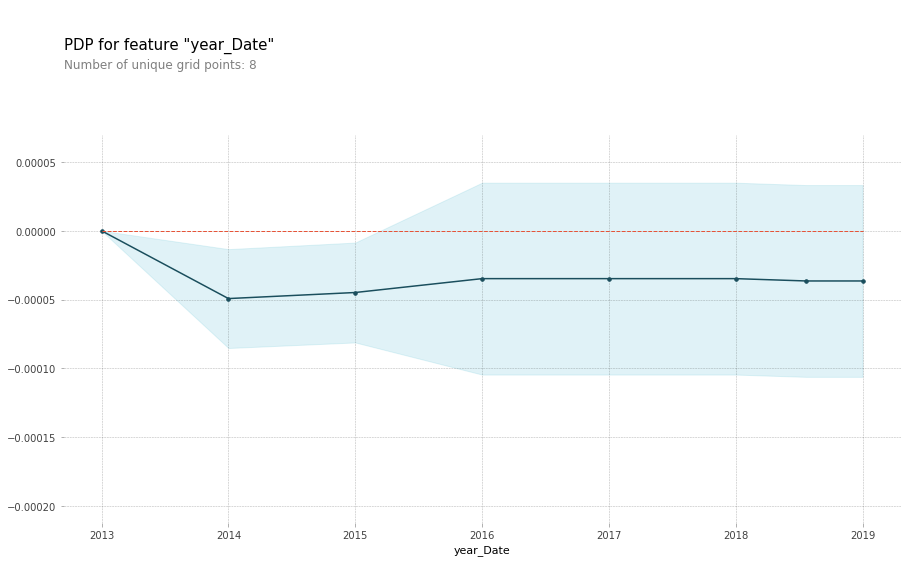

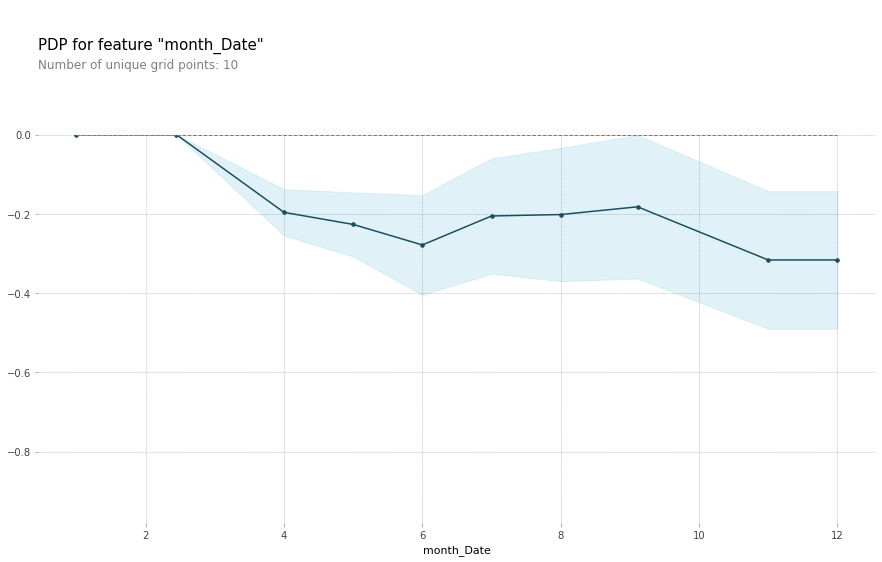

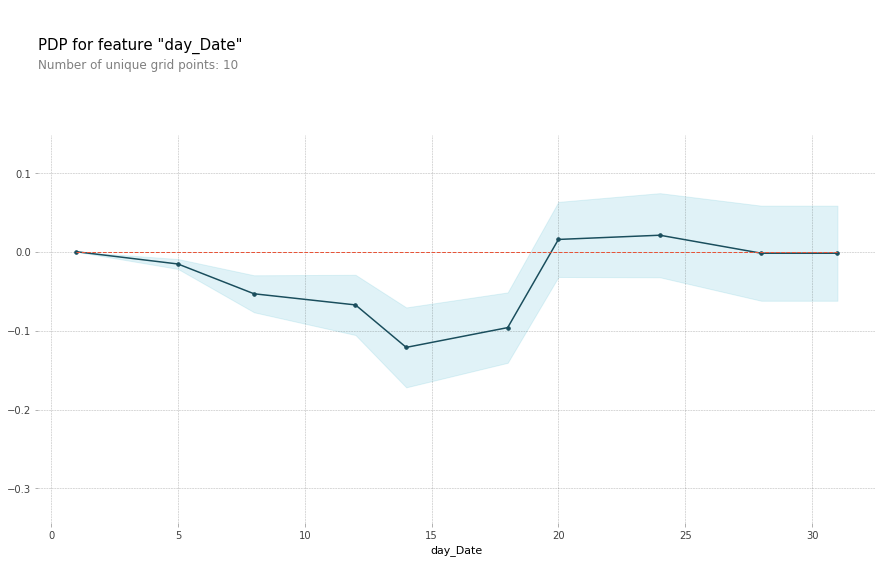

In [0]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

for j in X_test.columns :
  feature_names = [i for i in X_test.columns]

  feature = j
  # Create the data that we will plot
  pdp_isolate = pdp.pdp_isolate(model=gbm, dataset=X_test, model_features=feature_names, feature=feature)

  # plot it
  pdp.pdp_plot(pdp_isolate, feature)
  plt.show()

In [0]:
df_drop.head()

CO1  USGG5YRIndex  USGG10YRIndex  ...  year_Date  month_Date  day_Date
0  10585.9832          1.35           1.53  ...       2019          10         4
1  11257.0953          1.56           1.68  ...       2019           9        27
2  11646.2504          1.60           1.72  ...       2019           9        20
3  10889.5330          1.63           1.77  ...       2019           9        12
4  11132.5860          1.43           1.56  ...       2019           9         6

[5 rows x 26 columns]

In [0]:
df_new = df_drop.copy()
df_new['sub_rates'] = df_drop['Sovereign Change'] - df_drop['LKRUSDChange']

df_new.head()

CO1  USGG5YRIndex  USGG10YRIndex  ...  month_Date  day_Date  sub_rates
0  10585.9832          1.35           1.53  ...          10         4   0.202829
1  11257.0953          1.56           1.68  ...           9        27  -0.487455
2  11646.2504          1.60           1.72  ...           9        20  -0.130502
3  10889.5330          1.63           1.77  ...           9        12   0.192591
4  11132.5860          1.43           1.56  ...           9         6  -0.460445

[5 rows x 27 columns]

In [0]:
X, y = get_X_y(df_new, '5Year8Weeks')


X_train, X_test, y_train, y_test = data_split(X, y)

In [0]:
valid_score, gbm , valid_pred = base_model(X_train, X_test, y_train, y_test)

Starting training...
[1]	valid_0's rmse: 1.52066
Training until validation scores don't improve for 2500 rounds.
[2]	valid_0's rmse: 1.51498
[3]	valid_0's rmse: 1.50932
[4]	valid_0's rmse: 1.5037
[5]	valid_0's rmse: 1.49823
[6]	valid_0's rmse: 1.49291
[7]	valid_0's rmse: 1.48757
[8]	valid_0's rmse: 1.48219
[9]	valid_0's rmse: 1.47692
[10]	valid_0's rmse: 1.47169
[11]	valid_0's rmse: 1.4665
[12]	valid_0's rmse: 1.46117
[13]	valid_0's rmse: 1.45577
[14]	valid_0's rmse: 1.4505
[15]	valid_0's rmse: 1.44526
[16]	valid_0's rmse: 1.44007
[17]	valid_0's rmse: 1.43493
[18]	valid_0's rmse: 1.42964
[19]	valid_0's rmse: 1.4244
[20]	valid_0's rmse: 1.41934
[21]	valid_0's rmse: 1.41413
[22]	valid_0's rmse: 1.409
[23]	valid_0's rmse: 1.40386
[24]	valid_0's rmse: 1.39875
[25]	valid_0's rmse: 1.39375
[26]	valid_0's rmse: 1.38911
[27]	valid_0's rmse: 1.38452
[28]	valid_0's rmse: 1.37994
[29]	valid_0's rmse: 1.37546
[30]	valid_0's rmse: 1.37094
[31]	valid_0's rmse: 1.36628
[32]	valid_0's rmse: 1.36164
[3

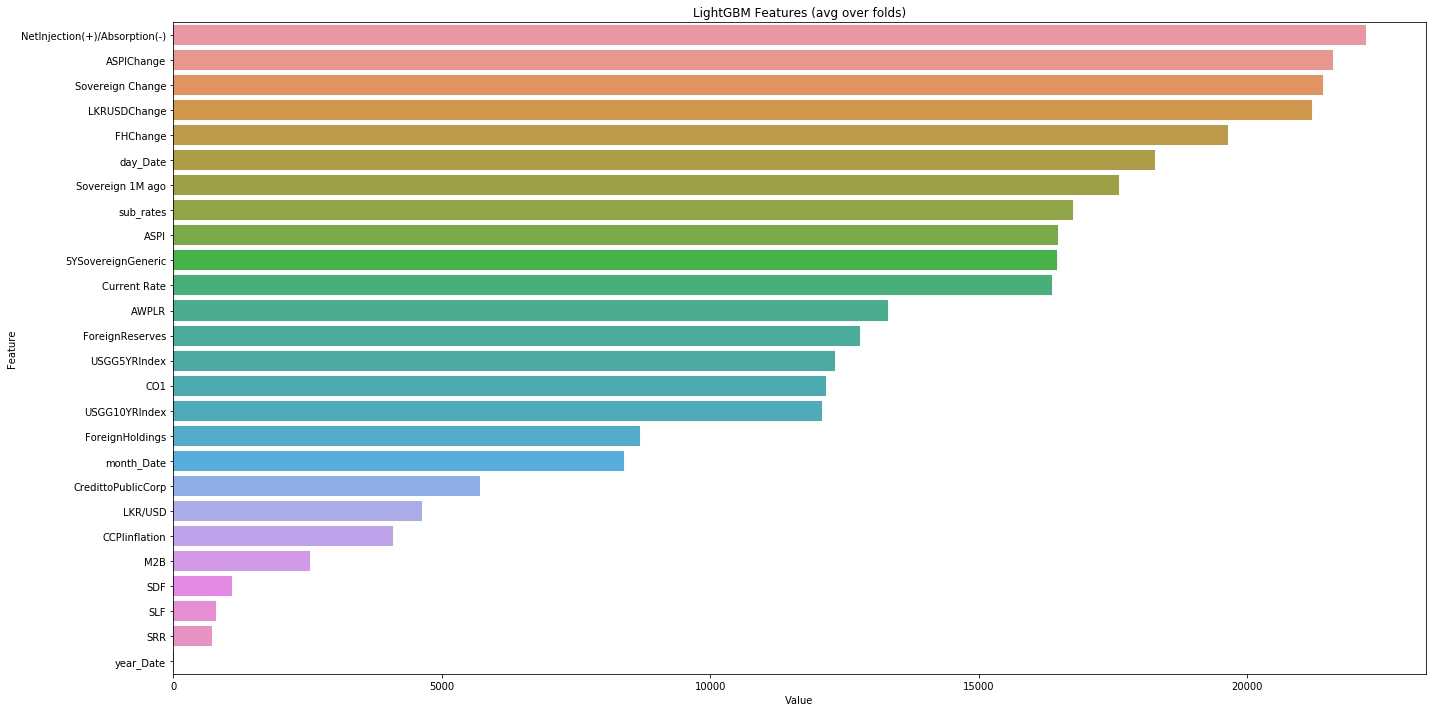

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')